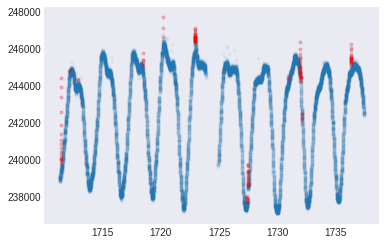

In [26]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import simps, quad
from astropy.io import fits

plt.style.use("seaborn-dark")
data = np.loadtxt("trended_lightcurve_3.out")
pdcflux = data[:,1]
time = data[:,0]
trend = data[:,2]
flarestamps = data[:,3]
flaretimes = time[flarestamps == 1.0]
flareflux= pdcflux[flarestamps == 1.0]
plt.plot(time, pdcflux,'.',alpha=0.05)
plt.plot(flaretimes, flareflux, 'r.',alpha=0.2)

Then define the functions we did in the previous notebook:

In [34]:
K_B = 1.3806485e-23
C_PLANCK = 6.62607004e-34
C_C = 2.99792458e8
SIGMA_SB = 5.670374419e-8
LAMBDA_MIN = 454.06
LAMBDA_MAX = 1129.15
NANOMETER = 1.0e-9
ERG = 1.0e-7
R_SUN = 696340000.0
DAY = 86400

def Response_TESS():
    
    '''
    Returns the TESS response curve as a function of the wavelength
    lambd. It's a spline interpolation 
    of the TESS response function.
    '''
    
    responsefile = "tess-response-function-v1.0.csv"
    rs = np.genfromtxt(responsefile, delimiter=',')
    f = interp1d(rs[:,0], rs[:,1])
    return f

R_tess = Response_TESS()

def B(lambd, T):
    
    '''
    The Planck distribution as a function of wavelength (in nanometers)
    Returns the spectral energy density rather than spectral density, 
    in units of watts / sqm (area) / m (wavelength) / sr (solid angle)
    '''
    
    l = lambd*NANOMETER
    denom = np.exp(C_PLANCK*C_C/(l*K_B*T)) - 1.
    num = 2. * C_PLANCK * C_C**2. * l**(-5.)
    return num/denom

def L(lambd):
    return B(lambd, T)*R_tess(lambd)

def Lp_STAR(R_star, T_star, R_TESS):

    '''
    Luminosity of the star in the TESS wavelength band
    '''
    
    integrand = lambda lam : B(lam, T_star) * R_TESS(lam)
    r = np.arange(LAMBDA_MIN,LAMBDA_MAX)
    integr = simps(integrand(r), r)*NANOMETER
    
    return np.pi* np.pi * R_star**2 * integr # radiance -> flux density on a sphere -> luminosity

def Lp_FLARE_DENSITY(T_flare, R_TESS):

    '''
    Flux density of a flare in the TESS band, on its effective spherical area
    '''
    
    integrand = lambda lam : B(lam, T_flare) * R_TESS(lam)
    r = np.arange(LAMBDA_MIN,LAMBDA_MAX)
    integr = simps(integrand(r), r)*NANOMETER
    
    return np.pi * integr
    
    
def A_flare(rel_amp, LpS, LpF, R_STAR):

    '''
    Returns the estimated effective area of the flare, given the
    relative amplitude from the normalized lightcurve;
    the luminosity of the star, and the luminosity of the flare per unit area
    '''
    
    return rel_amp*LpS/LpF#*R_STAR
    

def L_flare(T_flare, A_f):
    
    '''
    The luminosity of the flare at a given time:
    takes in the area of the flare and its temperature
    '''
    
    return SIGMA_SB * T_flare**4. * A_f
    

def E_flare(amps, times, T_flare, LpS, LpF, R_star):
    
    '''
    The energy of the flare. Takes in the amplitude,
    and pre-calculated values for the luminosity of the 
    star and the luminosity of the flare per unit area
    '''
    
    L_f = lambda amp : L_flare(T_flare, A_flare(amp, LpS, LpF, R_star)) 
    integral = simps(L_f(amps), times)
    return integral

Then take down some facts about EK Dra: we need its effective temperature and its radius. Use the same FITS headers as in Notebook 1.

In [31]:
hdul = fits.open('tess2019226182529-s0015-0000000159613900-0151-s_lc.fits')
hdr0 = hdul[0].header
print("Radius = "+str(hdr0['RADIUS'])+" R_o")
print("Temperature = "+str(hdr0['TEFF'])+" K")
T_STAR = hdr0['TEFF']
R_STAR = hdr0['RADIUS']*R_SUN
print(R_STAR)
T_FLARE = 9000.0
hdul.close()
LpS = Lp_STAR(R_STAR, T_STAR, R_tess)
LpF = Lp_FLARE_DENSITY(T_FLARE, R_tess)
print(LpS)
print(4.*Lp_STAR(R_SUN, 5780.0, R_tess))
print(np.pi*SIGMA_SB*R_STAR**2*T_STAR**4) # the luminosity of the star

Radius = 0.98715699 R_o
Temperature = 5647.0 K
687396898.4166
2.9100847755600913e+25
1.2953159368517999e+26
8.559490154868523e+25


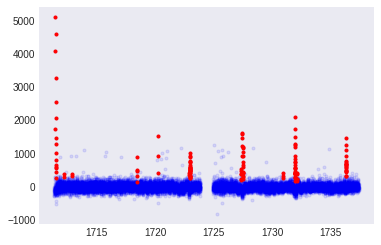

In [13]:
plt.plot(time,pdcflux-trend,"b.",alpha=0.1)
plt.plot(flaretimes, flareflux-trend[flarestamps==1.0], 'r.')

In [32]:
flare_energies = []
flare_times = []
in_flare = False
flare_dur = 0
pdcflux_ratio = (pdcflux-trend)/trend
for i in range(len(pdcflux)):
    if flarestamps[i] == 1:
        in_flare = True
        flare_dur += 1
    elif in_flare:
        amps = pdcflux_ratio[i-flare_dur : i]
        ts = time[i-flare_dur : i]*DAY
        Ef = E_flare(amps, ts, T_FLARE, LpS, LpF, R_STAR)
        flare_energies.append(Ef/ERG)
        flare_times.append(time[i-flare_dur])
        in_flare = False
        flare_dur = 0

for i in range(len(flare_energies)):
    print("{:.2e} erg, time: {:.1f}".format(flare_energies[i], flare_times[i]))

2.07e+34 erg, time: 1711.5
2.34e+32 erg, time: 1712.2
2.44e+32 erg, time: 1712.9
1.21e+33 erg, time: 1718.5
1.27e+33 erg, time: 1720.2
9.94e+33 erg, time: 1722.9
1.23e+33 erg, time: 1727.3
1.04e+34 erg, time: 1727.5
4.94e+32 erg, time: 1730.9
1.27e+34 erg, time: 1731.9
8.05e+32 erg, time: 1732.1
8.76e+33 erg, time: 1736.3


Still needs work. In particular there is one flare towards the end with a massive area under it, but does not get adequately described by the flare candidate tagger.